In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy import ndimage, misc
from skimage.morphology import skeletonize
import sklearn
from sklearn import linear_model
from sklearn import model_selection 
from tqdm import tqdm
import cv2
import tifffile
import cupy as cp
import matplotlib
from cupyx.scipy import ndimage
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
import random
import time
from PIL import Image
import pickle

In [14]:
df = pd.read_csv("all_sigmas_df_comb.csv")

X, y = df.iloc[:, :-4], df.iloc[:, -1] 
svr = SVR(kernel='rbf')

def backward_elim(X_iter, y, model):
    improving = True

    while improving: 
        feat_ix = list(range(X_iter.shape[1]))
        ref_error = cross_val_score(model, X_iter, y, cv = 5, scoring = "neg_mean_squared_error").mean()

        diff = 0
        min_ix = 0
        for ix in feat_ix:
            cols = feat_ix[:ix] + feat_ix[ix+1:]
            temp_df = X_iter.iloc[:, cols]
            temp_error = cross_val_score(model, temp_df, y, cv = 5, scoring = "neg_mean_squared_error").mean()
            temp_diff = ref_error - temp_error
            if temp_diff <= diff:
                print(temp_error)
                min_ix = ix
                diff = temp_diff

        if diff == 0:
            print("nothing changed")
            improving = False
        else:
            cols = feat_ix[:min_ix] + feat_ix[min_ix+1:]
            X_iter = X_iter.iloc[:, cols]
    return X_iter

In [15]:
hi = backward_elim(X, y, svr)

-0.024981090688798543
-0.02497745061075149
-0.02495586216455499
-0.024908551637264888
-0.02489794597149168
-0.02487288166870965
-0.02485584259045901
-0.02485317485155874
-0.024782153346081245
-0.024773427383447514
-0.02476591412104233
-0.02476579614357066
-0.02469052410666315
-0.02467424633972378
-0.024620848200346247
-0.024601788418802298
-0.024563610077712142
-0.024466923227479762
-0.024463770461514187
-0.024460018263999343
-0.024457754242108647
-0.024406176188923028
-0.024401681417715666
-0.024398872153674256
-0.024396641087705832
-0.02439607737513179
-0.024367606447321867
-0.02435961258692472
-0.02435612361941223
nothing changed


In [4]:
hi.head()

,200_density,200_grad,400_grad,800_grad,1000_density,1000_grad
0,8656.933030,112.218825,70.007968,42.114888,7931.179657,43.053865
1,8656.933030,112.218825,67.579849,38.268426,8386.931213,42.054073
2,7391.419336,80.107744,13.497684,46.010267,8048.149879,48.104070
3,7590.690018,75.739903,95.255350,67.548575,9861.872469,64.893983
4,7582.769376,76.460920,46.367691,40.382193,5820.748546,40.637919


In [5]:
hi.corr()

,200_density,200_grad,400_grad,800_grad,1000_density,1000_grad
200_density,1.000000,0.807963,0.346992,-0.008590,0.342393,-0.026775
200_grad,0.807963,1.000000,0.475441,0.023249,0.249998,-0.008904
400_grad,0.346992,0.475441,1.000000,0.371106,0.296543,0.169950
800_grad,-0.008590,0.023249,0.371106,1.000000,-0.115083,0.904203
1000_density,0.342393,0.249998,0.296543,-0.115083,1.000000,-0.267472
1000_grad,-0.026775,-0.008904,0.169950,0.904203,-0.267472,1.000000


In [35]:
df = pd.read_csv("all_sigmas_df_comb.csv")

X, y = df.iloc[:, :-4], df.iloc[:, -1] 
svr = SVR(kernel='rbf')

def backward_elim(X_iter, y, model, n_feats):
    n_iter = X_iter.shape[1]
    
    while n_iter > n_feats:
        feat_ix = list(range(X_iter.shape[1]))
    
        min_ix = 0
        min_error = -np.infty
        for ix in feat_ix:
            cols = feat_ix[:ix] + feat_ix[ix+1:]
            temp_df = X_iter.iloc[:, cols]
            temp_error = cross_val_score(model, temp_df, y, cv = 5, scoring = "neg_mean_squared_error").mean()
            if temp_error > min_error:
                min_ix = ix
                min_error = temp_error

        cols = feat_ix[:min_ix] + feat_ix[min_ix+1:]
        X_iter = X_iter.iloc[:, cols]
        n_iter = X_iter.shape[1]
        
    return X_iter

In [50]:
he = backward_elim(X, y, svr, 2)

-0.024981090688798543
-0.02495586216455499
-0.024908551637264888
-0.024782153346081245
-0.02469052410666315
-0.024601788418802298
-0.024466923227479762
-0.024463770461514187
-0.024460018263999343
-0.024457754242108647
-0.02439607737513179
-0.02435612361941223
-0.02436027588636917
-0.024421404760389672
-0.024562454565646354
-0.023786500854477716


In [51]:
he

,200_density,1000_density
0,8656.933030,7931.179657
1,8656.933030,8386.931213
2,7391.419336,8048.149879
3,7590.690018,9861.872469
4,7582.769376,5820.748546
...,...,...
563,7391.488390,6968.885363
564,7467.671663,6695.242020
565,7588.002272,11126.802710
566,10359.303730,12134.600280


In [45]:
X

,200_density,200_grad,400_density,400_grad,600_density,600_grad,800_density,800_grad,1000_density,1000_grad,1400_density,1400_grad,1800_density,1800_grad,2200_density,2200_grad,2600_density,2600_grad
0,8656.933030,112.218825,7597.341244,70.007968,7041.797754,44.197520,7265.171755,42.114888,7931.179657,43.053865,9357.020373,40.812607,10715.253790,39.167871,12088.088670,38.284992,13368.23758,36.751678
1,8656.933030,112.218825,7611.521379,67.579849,7140.335794,37.316788,7536.277455,38.268426,8386.931213,42.054073,10089.171180,41.668772,11651.165790,40.665506,13123.984940,39.661475,14406.29518,37.682455
2,7391.419336,80.107744,4215.056702,13.497684,4638.139568,35.613095,6278.532303,46.010267,8048.149879,48.104070,11146.420200,47.666961,13602.005500,46.229137,15450.364510,43.322769,16751.73490,39.498419
3,7590.690018,75.739903,6942.516611,95.255350,7384.879493,74.448795,8365.924466,67.548575,9861.872469,64.893983,12900.936810,58.666668,15294.051010,51.938276,16943.458540,45.582341,18011.32870,40.099268
4,7582.769376,76.460920,5505.440377,46.367691,5126.986000,42.229020,5316.481195,40.382193,5820.748546,40.637919,7421.049149,42.618513,9131.239665,42.066584,10666.517440,39.934947,11996.08287,37.338831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,7391.488390,80.099920,4399.506198,20.253092,4737.411992,40.287718,5753.777808,44.706556,6968.885363,46.147981,9523.047025,47.455993,11655.915500,45.298107,13289.401200,41.802565,14546.45904,38.300919
564,7467.671663,77.656137,5222.537580,43.009740,5206.152512,48.600261,5931.587321,51.284280,6695.242020,47.886591,7791.301394,39.133605,8762.697630,34.950497,9870.118735,33.482943,11083.77693,32.855150
565,7588.002272,75.838192,6870.733389,85.372078,8291.819073,73.011871,9820.061819,58.599192,11126.802710,49.273961,12743.112910,39.229716,13775.062880,36.398880,14819.159640,36.083035,15872.99830,35.416856
566,10359.303730,174.224522,8019.558672,32.019697,9636.946672,42.788995,11241.619530,46.301571,12134.600280,42.174883,13499.213720,38.771214,14905.839180,38.073480,16238.295430,37.516174,17356.84167,36.064823


In [60]:
X_iter.describe()

,200_density,200_grad,400_grad,800_grad,1000_density,1000_grad
count,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000
mean,9880.818725,128.527084,59.281641,35.422275,13452.977513,32.591671
std,2823.495949,63.582200,35.139654,18.138519,3454.388078,16.666977
min,7391.419336,58.519411,8.630093,2.673049,3325.308341,1.072835
25%,7585.390544,78.933225,35.240284,20.725176,10916.177300,18.612272
50%,8656.933030,98.153657,52.777908,34.296799,13505.551580,31.923254
75%,11792.435990,173.717946,74.072266,48.209166,15863.480498,44.817750
max,23871.501500,384.513845,235.986109,104.498116,22268.265600,83.647192


In [57]:
X_iter.corr()

,200_density,200_grad,400_grad,800_grad,1000_density,1000_grad
200_density,1.000000,0.807963,0.346992,-0.008590,0.342393,-0.026775
200_grad,0.807963,1.000000,0.475441,0.023249,0.249998,-0.008904
400_grad,0.346992,0.475441,1.000000,0.371106,0.296543,0.169950
800_grad,-0.008590,0.023249,0.371106,1.000000,-0.115083,0.904203
1000_density,0.342393,0.249998,0.296543,-0.115083,1.000000,-0.267472
1000_grad,-0.026775,-0.008904,0.169950,0.904203,-0.267472,1.000000


In [4]:
mins = X_iter.describe().iloc[3, :].values

In [5]:
maxs = X_iter.describe().iloc[-1, :].values

In [6]:
stds = X_iter.describe().iloc[2, :].values

In [7]:
min_samps = []
for a_min in mins:
    min_samps.append(np.linspace(0, a_min, 20))

In [48]:
max_samps = []
for i in range(len(maxs)):
    max_samps.append(np.linspace(maxs[i]+ 2*stds[i], maxs[i] + 3*stds[i], 20))

In [49]:
svr.fit(X_iter, y)

SVR()

In [50]:
high_vals = []
for l in max_samps:
    high_vals.append(np.random.choice(l, 1))

(array([200., 262.,  48.,  28.,  16.,   4.,   2.,   0.,   5.,   3.]),
 array([0.07942377, 0.10272443, 0.12602509, 0.14932575, 0.17262642,
        0.19592708, 0.21922774, 0.2425284 , 0.26582907, 0.28912973,
        0.31243039]),
 <BarContainer object of 10 artists>)

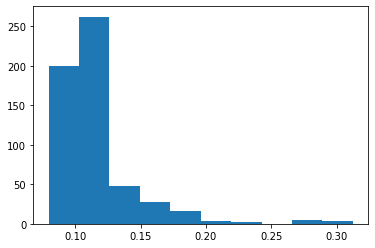

In [51]:
plt.hist(svr.predict(X_iter))

In [52]:
svr.predict(np.array(high_vals).reshape(1,-1)), svr.predict(np.array([90000,90000,90000,90000,90000]).reshape(1,-1))

(array([0.57815822]), array([0.26652695]))